# HR Analytics - Employee Churn Analysis
---

This module performs comprehensive exploratory data analysis on HR data
to understand employee churn patterns and key factors affecting retention.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sqlalchemy import create_engine
from tabulate import tabulate
import seaborn as sns
from utils import plot_numerical_distributions, plot_categorical_features
from config import DB_USERNAME, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME
import uuid

In [2]:
# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from tabulate import tabulate
from utils import plot_numerical_distributions, plot_categorical_features

class HRDataAnalyzer:
    """
    A class to handle HR data analysis operations including data loading,
    preprocessing, and exploratory data analysis with enhanced visualizations.
    """

    def __init__(self):
        """Initialize the HR Data Analyzer with database connection."""
        self.connection_string = f"postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
        self.engine = create_engine(self.connection_string)
        self.df_hr_data = None
        self.df_new_employees = None
        self.numerical_cols = []
        self.categorical_cols = []
        # Set a clean style with minimal color usage
        sns.set_style("whitegrid")
        plt.rcParams.update({
            'font.family': 'Arial',
            'font.size': 12,
            'axes.titlesize': 16,
            'axes.labelsize': 14,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12,
            'figure.figsize': (10, 6),
            'axes.grid': True,
            'grid.alpha': 0.3,
            'axes.edgecolor': 'black'
        })

    def load_data(self):
        """Load HR data from database."""
        print("Loading data from database...")
        self.df_hr_data = pd.read_sql("SELECT * FROM tbl_hr_data", self.engine)
        self.df_new_employees = pd.read_sql(
            "SELECT * FROM tbl_new_employees", self.engine
        )
        print("Data loaded successfully!")

    def display_data_overview(self):
        """Display basic information about the loaded datasets."""
        print("\n" + "=" * 50)
        print("DATA OVERVIEW")
        print("=" * 50)

        print("\nHR Data Sample:")
        print(tabulate(self.df_hr_data.head(), headers="keys", tablefmt="psql"))

        print("\nNew Employees Data Sample:")
        print(tabulate(self.df_new_employees.head(), headers="keys", tablefmt="psql"))

        print(f"\nHR Data Shape: {self.df_hr_data.shape}")
        print(f"New Employees Data Shape: {self.df_new_employees.shape}")

    def perform_data_quality_check(self):
        """Perform basic data quality checks."""
        print("\n" + "=" * 50)
        print("DATA QUALITY CHECK")
        print("=" * 50)

        print("\nData Info:")
        self.df_hr_data.info()

        print(f"\nMissing Values:")
        missing_values = self.df_hr_data.isnull().sum()
        print(
            missing_values[missing_values > 0]
            if missing_values.sum() > 0
            else "No missing values found"
        )

        print(f"\nDuplicate Records: {self.df_hr_data.duplicated().sum()}")

    def preprocess_data(self):
        """Preprocess the HR data for analysis."""
        print("\n" + "=" * 50)
        print("DATA PREPROCESSING")
        print("=" * 50)

        if "employee_id" in self.df_hr_data.columns:
            self.df_hr_data = self.df_hr_data.drop(columns=["employee_id"])
            print("Dropped employee_id column")

        self.df_hr_data["satisfaction_level_cat"] = pd.cut(
            self.df_hr_data["satisfaction_level"],
            bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
            labels=["Very Low", "Low", "Medium", "High", "Very High"],
        ).astype("category").cat.reorder_categories(
            ["Very Low", "Low", "Medium", "High", "Very High"], ordered=True
        )

        self.df_hr_data["last_evaluation_cat"] = pd.cut(
            self.df_hr_data["last_evaluation"],
            bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
            labels=["Very Low", "Low", "Medium", "High", "Very High"],
        ).astype("category").cat.reorder_categories(
            ["Very Low", "Low", "Medium", "High", "Very High"], ordered=True
        )

        self._identify_column_types()
        print("Data preprocessing completed!")

    def _identify_column_types(self):
        """Identify numerical and categorical columns."""
        self.numerical_cols = self.df_hr_data.select_dtypes(
            include=["number"]
        ).columns.tolist()
        self.categorical_cols = self.df_hr_data.select_dtypes(
            include=["object", "category"]
        ).columns.tolist()

        for col in self.df_hr_data.columns:
            if self.df_hr_data[col].nunique() < 10 and col not in self.categorical_cols:
                self.categorical_cols.append(col)
                if col in self.numerical_cols:
                    self.numerical_cols.remove(col)

        print(f"\nNumerical Columns: {self.numerical_cols}")
        print(f"Categorical Columns: {self.categorical_cols}")

    def perform_univariate_analysis(self):
        """Perform univariate analysis using custom plotting functions with tab10 palette."""
        print("\n" + "=" * 80)
        print("UNIVARIATE ANALYSIS")
        print("=" * 80)

        print("\nAnalyzing numerical features...")
        plot_numerical_distributions(self.df_hr_data, self.numerical_cols, palette="tab10")

        print("Analyzing categorical features...")
        plot_categorical_features(self.df_hr_data, self.categorical_cols, palette="tab10")

    def analyze_churn_by_satisfaction(self):
        """Analyze relationship between satisfaction level and churn with labeled bars and borders."""
        print("\n" + "-" * 50)
        print("SATISFACTION LEVEL vs CHURN ANALYSIS")
        print("-" * 50)

        satisfaction_churn = (
            self.df_hr_data.groupby("satisfaction_level_cat")["Quit_the_Company"]
            .mean()
            .reset_index()
        )
        satisfaction_churn["Quit_Rate_Percentage"] = (
            satisfaction_churn["Quit_the_Company"] * 100
        )

        print("\nChurn Rate by Satisfaction Level:")
        print(
            tabulate(
                satisfaction_churn, headers="keys", tablefmt="psql", floatfmt=".2f"
            )
        )

        plt.figure(figsize=(10, 6))
        bars = sns.barplot(
            data=satisfaction_churn,
            x="satisfaction_level_cat",
            y="Quit_Rate_Percentage",
            color="teal",
            edgecolor="black",
            linewidth=1.5
        )
        for bar in bars.patches:
            bars.annotate(
                f"{bar.get_height():.1f}%",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold"
            )
        plt.title("Employee Churn Rate by Satisfaction Level", fontweight="bold")
        plt.xlabel("Satisfaction Level")
        plt.ylabel("Churn Rate (%)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def analyze_churn_by_department(self):
        """Analyze relationship between department and churn with labeled bars and borders."""
        print("\n" + "-" * 50)
        print("DEPARTMENT vs CHURN ANALYSIS")
        print("-" * 50)

        dept_churn = (
            self.df_hr_data.groupby("Departments")["Quit_the_Company"]
            .mean()
            .reset_index()
        )
        dept_churn["Quit_Rate_Percentage"] = dept_churn["Quit_the_Company"] * 100
        dept_churn = dept_churn.sort_values("Quit_Rate_Percentage", ascending=False)

        print("\nChurn Rate by Department:")
        print(tabulate(dept_churn, headers="keys", tablefmt="psql", floatfmt=".2f"))

        plt.figure(figsize=(12, 6))
        bars = sns.barplot(
            data=dept_churn,
            x="Departments",
            y="Quit_Rate_Percentage",
            color="coral",
            edgecolor="black",
            linewidth=1.5
        )
        for bar in bars.patches:
            bars.annotate(
                f"{bar.get_height():.1f}%",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold"
            )
        plt.title("Employee Churn Rate by Department", fontweight="bold")
        plt.xlabel("Department")
        plt.ylabel("Churn Rate (%)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    def analyze_churn_by_salary(self):
        """Analyze relationship between salary level and churn with labeled bars and borders."""
        print("\n" + "-" * 50)
        print("SALARY LEVEL vs CHURN ANALYSIS")
        print("-" * 50)

        salary_churn = (
            self.df_hr_data.groupby("salary")["Quit_the_Company"].mean().reset_index()
        )
        salary_churn["Quit_Rate_Percentage"] = salary_churn["Quit_the_Company"] * 100
        salary_churn = salary_churn.sort_values("Quit_Rate_Percentage", ascending=False)

        print("\nChurn Rate by Salary Level:")
        print(tabulate(salary_churn, headers="keys", tablefmt="psql", floatfmt=".2f"))

        plt.figure(figsize=(8, 6))
        bars = sns.barplot(
            data=salary_churn,
            x="salary",
            y="Quit_Rate_Percentage",
            color="lightblue",
            edgecolor="black",
            linewidth=1.5
        )
        for bar in bars.patches:
            bars.annotate(
                f"{bar.get_height():.1f}%",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold"
            )
        plt.title("Employee Churn Rate by Salary Level", fontweight="bold")
        plt.xlabel("Salary Level")
        plt.ylabel("Churn Rate (%)")
        plt.tight_layout()
        plt.show()

    def analyze_churn_by_evaluation(self):
        """Analyze relationship between last evaluation and churn with labeled bars and borders."""
        print("\n" + "-" * 50)
        print("LAST EVALUATION vs CHURN ANALYSIS")
        print("-" * 50)

        eval_churn = (
            self.df_hr_data.groupby("last_evaluation_cat")["Quit_the_Company"]
            .mean()
            .reset_index()
        )
        eval_churn["Quit_Rate_Percentage"] = eval_churn["Quit_the_Company"] * 100

        print("\nChurn Rate by Last Evaluation Level:")
        print(tabulate(eval_churn, headers="keys", tablefmt="psql", floatfmt=".2f"))

        plt.figure(figsize=(10, 6))
        bars = sns.barplot(
            data=eval_churn,
            x="last_evaluation_cat",
            y="Quit_Rate_Percentage",
            color="teal",
            edgecolor="black",
            linewidth=1.5
        )
        for bar in bars.patches:
            bars.annotate(
                f"{bar.get_height():.1f}%",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold"
            )
        plt.title("Employee Churn Rate by Last Evaluation Level", fontweight="bold")
        plt.xlabel("Last Evaluation Level")
        plt.ylabel("Churn Rate (%)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def analyze_churn_by_projects(self):
        """Analyze relationship between number of projects and churn with labeled bars and borders."""
        print("\n" + "-" * 50)
        print("NUMBER OF PROJECTS vs CHURN ANALYSIS")
        print("-" * 50)

        projects_churn = (
            self.df_hr_data.groupby("number_project")["Quit_the_Company"]
            .mean()
            .reset_index()
        )
        projects_churn["Quit_Rate_Percentage"] = (
            projects_churn["Quit_the_Company"] * 100
        )

        print("\nChurn Rate by Number of Projects:")
        print(tabulate(projects_churn, headers="keys", tablefmt="psql", floatfmt=".2f"))

        plt.figure(figsize=(10, 6))
        bars = sns.barplot(
            data=projects_churn,
            x="number_project",
            y="Quit_Rate_Percentage",
            color="purple",
            edgecolor="black",
            linewidth=1.5
        )
        for bar in bars.patches:
            bars.annotate(
                f"{bar.get_height():.1f}%",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold"
            )
        plt.title("Employee Churn Rate by Number of Projects", fontweight="bold")
        plt.xlabel("Number of Projects")
        plt.ylabel("Churn Rate (%)")
        plt.tight_layout()
        plt.show()

    def analyze_churn_by_promotion(self):
        """Analyze relationship between promotion and churn with labeled bars and borders."""
        print("\n" + "-" * 50)
        print("PROMOTION vs CHURN ANALYSIS")
        print("-" * 50)

        promo_churn = (
            self.df_hr_data.groupby("promotion_last_5years")["Quit_the_Company"]
            .mean()
            .reset_index()
        )
        promo_churn["Quit_Rate_Percentage"] = promo_churn["Quit_the_Company"] * 100
        promo_churn["promotion_status"] = promo_churn["promotion_last_5years"].map(
            {0: "No Promotion", 1: "Promoted"}
        )

        print("\nChurn Rate by Promotion Status:")
        print(
            tabulate(
                promo_churn[["promotion_status", "Quit_Rate_Percentage"]],
                headers="keys",
                tablefmt="psql",
                floatfmt=".2f",
            )
        )

        plt.figure(figsize=(8, 6))
        bars = sns.barplot(
            data=promo_churn,
            x="promotion_status",
            y="Quit_Rate_Percentage",
            color="orange",
            edgecolor="black",
            linewidth=1.5
        )
        for bar in bars.patches:
            bars.annotate(
                f"{bar.get_height():.1f}%",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold"
            )
        plt.title("Employee Churn Rate by Promotion Status", fontweight="bold")
        plt.xlabel("Promotion in Last 5 Years")
        plt.ylabel("Churn Rate (%)")
        plt.tight_layout()
        plt.show()

    def analyze_churn_by_tenure(self):
        """Analyze relationship between time spent in company and churn with labeled bars and borders."""
        print("\n" + "-" * 50)
        print("TENURE vs CHURN ANALYSIS")
        print("-" * 50)

        tenure_churn = (
            self.df_hr_data.groupby("time_spend_company")["Quit_the_Company"]
            .mean()
            .reset_index()
        )
        tenure_churn["Quit_Rate_Percentage"] = tenure_churn["Quit_the_Company"] * 100

        print("\nChurn Rate by Tenure:")
        print(tabulate(tenure_churn, headers="keys", tablefmt="psql", floatfmt=".2f"))

        plt.figure(figsize=(10, 6))
        bars = sns.barplot(
            data=tenure_churn,
            x="time_spend_company",
            y="Quit_Rate_Percentage",
            color="green",
            edgecolor="black",
            linewidth=1.5
        )
        for bar in bars.patches:
            bars.annotate(
                f"{bar.get_height():.1f}%",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold"
            )
        plt.title("Employee Churn Rate by Tenure", fontweight="bold")
        plt.xlabel("Time Spent in Company (Years)")
        plt.ylabel("Churn Rate (%)")
        plt.tight_layout()
        plt.show()

    def analyze_churn_by_work_accident(self):
        """Analyze relationship between work accident and churn with labeled bars and borders."""
        print("\n" + "-" * 50)
        print("WORK ACCIDENT vs CHURN ANALYSIS")
        print("-" * 50)

        accident_churn = (
            self.df_hr_data.groupby("Work_accident")["Quit_the_Company"]
            .mean()
            .reset_index()
        )
        accident_churn["Quit_Rate_Percentage"] = (
            accident_churn["Quit_the_Company"] * 100
        )
        accident_churn["accident_status"] = accident_churn["Work_accident"].map(
            {0: "No Accident", 1: "Had Accident"}
        )

        print("\nChurn Rate by Work Accident Status:")
        print(
            tabulate(
                accident_churn[["accident_status", "Quit_Rate_Percentage"]],
                headers="keys",
                tablefmt="psql",
                floatfmt=".2f",
            )
        )

        plt.figure(figsize=(8, 6))
        bars = sns.barplot(
            data=accident_churn,
            x="accident_status",
            y="Quit_Rate_Percentage",
            color="grey",
            edgecolor="black",
            linewidth=1.5
        )
        for bar in bars.patches:
            bars.annotate(
                f"{bar.get_height():.1f}%",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold"
            )
        plt.title("Employee Churn Rate by Work Accident Status", fontweight="bold")
        plt.xlabel("Work Accident Status")
        plt.ylabel("Churn Rate (%)")
        plt.tight_layout()
        plt.show()

    def perform_complete_bivariate_analysis(self):
        """Perform complete bivariate analysis for all key factors."""
        print("\n" + "=" * 80)
        print("BIVARIATE ANALYSIS - CHURN FACTORS")
        print("=" * 80)

        self.analyze_churn_by_satisfaction()
        self.analyze_churn_by_department()
        self.analyze_churn_by_salary()
        self.analyze_churn_by_evaluation()
        self.analyze_churn_by_projects()
        self.analyze_churn_by_promotion()
        self.analyze_churn_by_tenure()
        self.analyze_churn_by_work_accident()

    def generate_summary_report(self):
        """Generate a comprehensive summary report."""
        print("\n" + "=" * 80)
        print("EXECUTIVE SUMMARY")
        print("=" * 80)

        total_employees = len(self.df_hr_data)
        total_churned = self.df_hr_data["Quit_the_Company"].sum()
        churn_rate = (total_churned / total_employees) * 100

        print(f"Total Employees: {total_employees:,}")
        print(f"Total Churned Employees: {total_churned:,}")
        print(f"Overall Churn Rate: {churn_rate:.2f}%")

        print("\nKEY INSIGHTS:")
        print("-" * 40)

        dept_risk = (
            self.df_hr_data.groupby("Departments")["Quit_the_Company"]
            .mean()
            .sort_values(ascending=False)
        )
        sat_risk = (
            self.df_hr_data.groupby("satisfaction_level_cat")["Quit_the_Company"]
            .mean()
            .sort_values(ascending=False)
        )

        print(
            f"• Highest risk department: {dept_risk.index[0]} ({dept_risk.iloc[0]*100:.1f}% churn rate)"
        )
        print(
            f"• Highest risk satisfaction group: {sat_risk.index[0]} ({sat_risk.iloc[0]*100:.1f}% churn rate)"
        )

        salary_risk = (
            self.df_hr_data.groupby("salary")["Quit_the_Company"]
            .mean()
            .sort_values(ascending=False)
        )
        print(
            f"• Highest risk salary group: {salary_risk.index[0]} ({salary_risk.iloc[0]*100:.1f}% churn rate)"
        )

In [ ]:
def main():
    """Main execution function."""
    print("=" * 80)
    print("HR ANALYTICS - EMPLOYEE CHURN ANALYSIS")
    print("=" * 80)

    # Initialize analyzer
    analyzer = HRDataAnalyzer()

    # Execute analysis pipeline
    try:
        analyzer.load_data()
        analyzer.display_data_overview()
        analyzer.perform_data_quality_check()
        analyzer.preprocess_data()
        analyzer.perform_univariate_analysis()
        analyzer.perform_complete_bivariate_analysis()
        analyzer.generate_summary_report()

        print("\n" + "=" * 80)
        print("ANALYSIS COMPLETED SUCCESSFULLY🥳")
        print("=" * 80)

    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        raise

HR ANALYTICS - EMPLOYEE CHURN ANALYSIS
Loading data from database...
Data loaded successfully!

DATA OVERVIEW

HR Data Sample:
+----+----------------------+-------------------+------------------+------------------------+----------------------+-----------------+--------------------+-------------------------+---------------+----------+---------------+
|    |   satisfaction_level |   last_evaluation |   number_project |   average_montly_hours |   time_spend_company |   Work_accident |   Quit_the_Company |   promotion_last_5years | Departments   | salary   | employee_id   |
|----+----------------------+-------------------+------------------+------------------------+----------------------+-----------------+--------------------+-------------------------+---------------+----------+---------------|
|  0 |                 0.38 |              0.53 |                2 |                    157 |                    3 |               0 |                  1 |                       0 | sales         | 

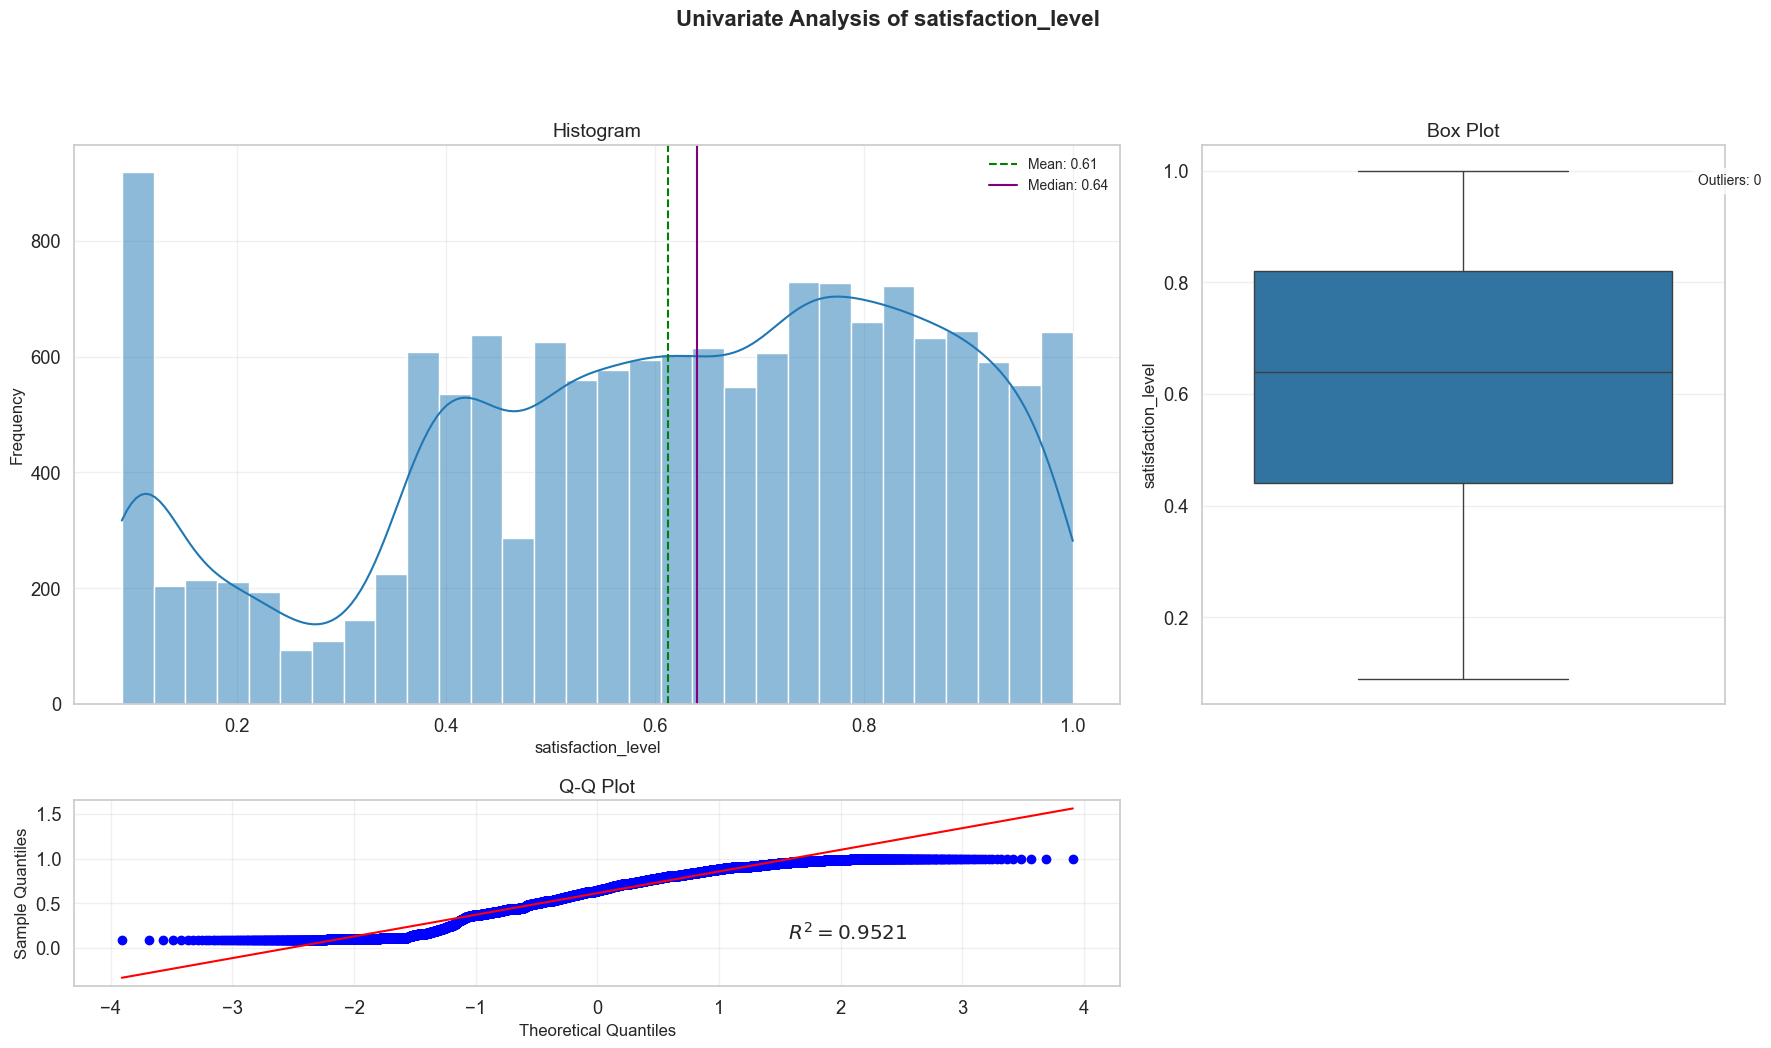


Summary Statistics for last_evaluation:
+----------+----------+
| Metric   |    Value |
|----------+----------|
| Count    | 15004    |
| Mean     |     0.72 |
| Median   |     0.72 |
| Std      |     0.17 |
| Min      |     0.36 |
| Max      |     1    |
| Skewness |    -0.03 |
| Kurtosis |    -1.24 |
+----------+----------+


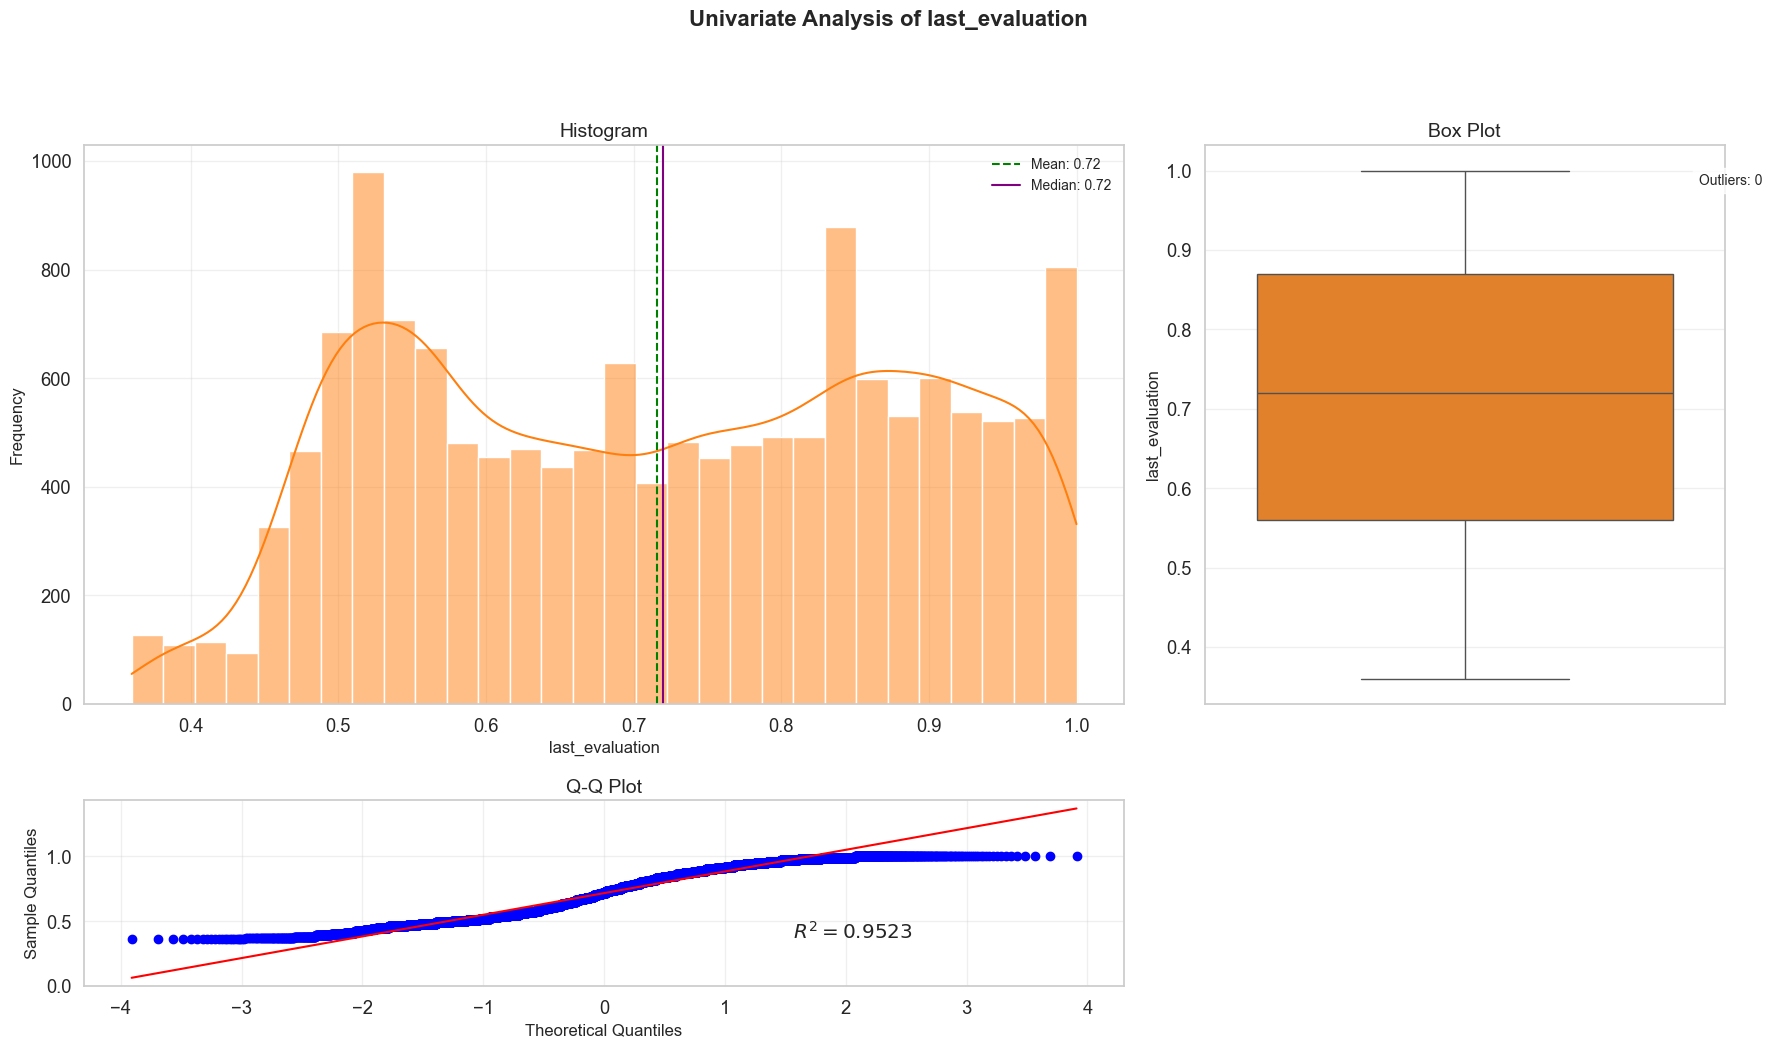


Summary Statistics for average_montly_hours:
+----------+----------+
| Metric   |    Value |
|----------+----------|
| Count    | 15004    |
| Mean     |   201.04 |
| Median   |   200    |
| Std      |    49.95 |
| Min      |    96    |
| Max      |   310    |
| Skewness |     0.05 |
| Kurtosis |    -1.14 |
+----------+----------+


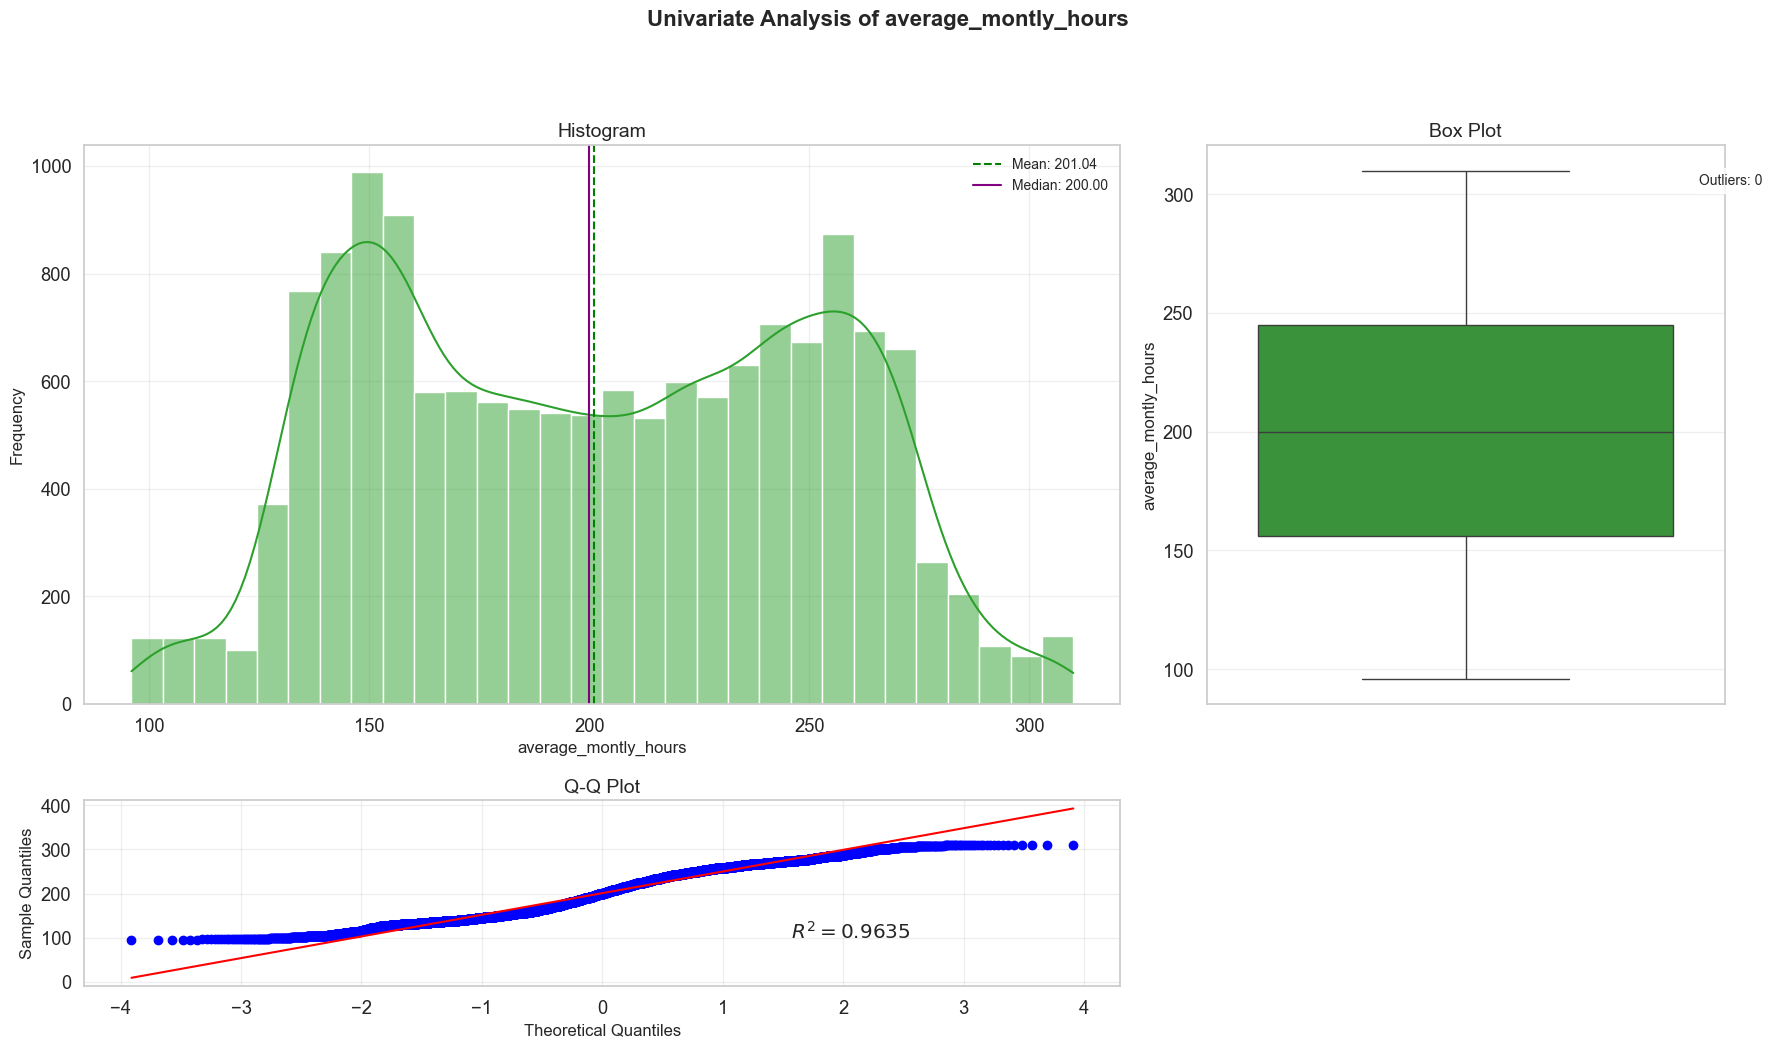

Analyzing categorical features...


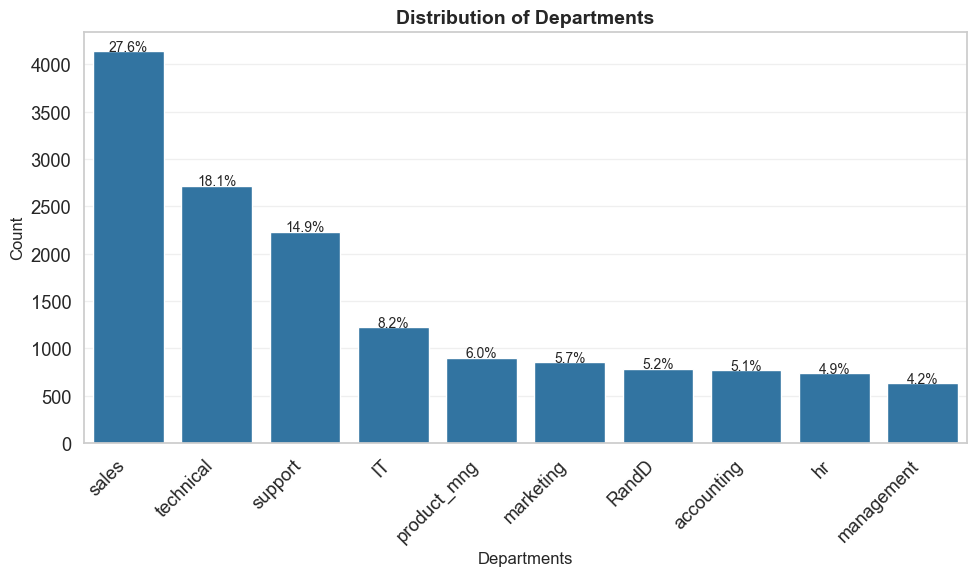


Summary for Departments:
Mode: sales
+-------------+---------+--------------------------+
| Value       |   Count |   Relative Frequency (%) |
|-------------+---------+--------------------------|
| sales       |    4140 |                     27.6 |
| technical   |    2720 |                     18.1 |
| support     |    2234 |                     14.9 |
| IT          |    1227 |                      8.2 |
| product_mng |     902 |                      6   |
| marketing   |     858 |                      5.7 |
| RandD       |     787 |                      5.2 |
| accounting  |     767 |                      5.1 |
| hr          |     739 |                      4.9 |
| management  |     630 |                      4.2 |
+-------------+---------+--------------------------+




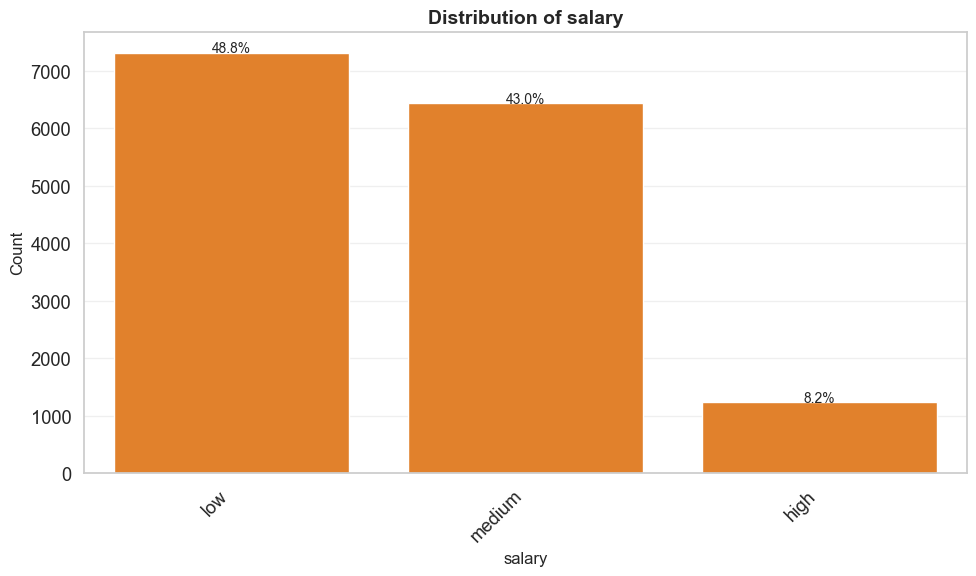


Summary for salary:
Mode: low
+---------+---------+--------------------------+
| Value   |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
| low     |    7321 |                     48.8 |
| medium  |    6446 |                     43   |
| high    |    1237 |                      8.2 |
+---------+---------+--------------------------+




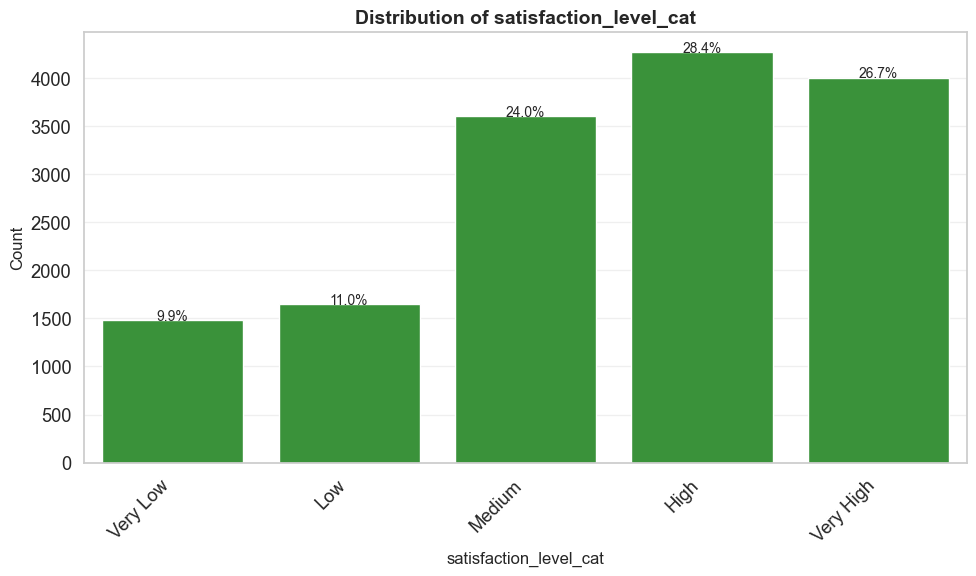


Summary for satisfaction_level_cat:
Mode: High
+-----------+---------+--------------------------+
| Value     |   Count |   Relative Frequency (%) |
|-----------+---------+--------------------------|
| High      |    4268 |                     28.4 |
| Very High |    4002 |                     26.7 |
| Medium    |    3605 |                     24   |
| Low       |    1650 |                     11   |
| Very Low  |    1479 |                      9.9 |
+-----------+---------+--------------------------+




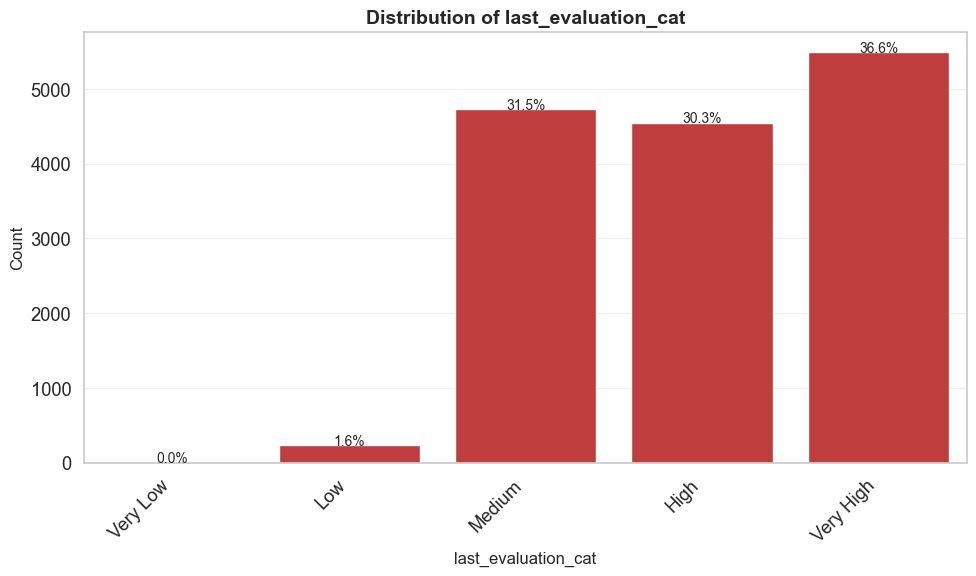


Summary for last_evaluation_cat:
Mode: Very High
+-----------+---------+--------------------------+
| Value     |   Count |   Relative Frequency (%) |
|-----------+---------+--------------------------|
| Very High |    5490 |                     36.6 |
| Medium    |    4731 |                     31.5 |
| High      |    4547 |                     30.3 |
| Low       |     236 |                      1.6 |
| Very Low  |       0 |                      0   |
+-----------+---------+--------------------------+




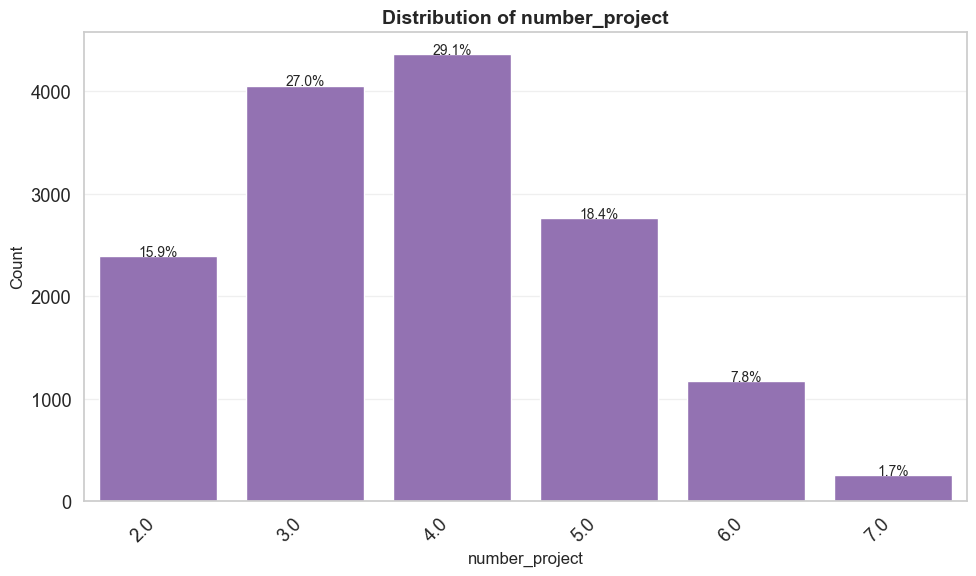


Summary for number_project:
Mode: 4.0
+---------+---------+--------------------------+
|   Value |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
|       4 |    4365 |                     29.1 |
|       3 |    4055 |                     27   |
|       5 |    2761 |                     18.4 |
|       2 |    2388 |                     15.9 |
|       6 |    1174 |                      7.8 |
|       7 |     256 |                      1.7 |
+---------+---------+--------------------------+




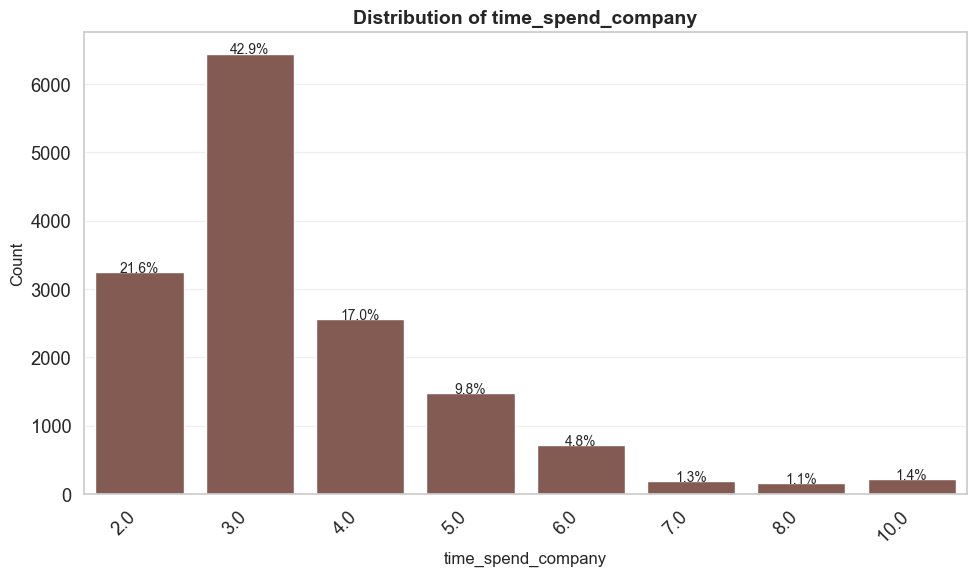


Summary for time_spend_company:
Mode: 3.0
+---------+---------+--------------------------+
|   Value |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
|       3 |    6443 |                     42.9 |
|       2 |    3244 |                     21.6 |
|       4 |    2557 |                     17   |
|       5 |    1473 |                      9.8 |
|       6 |     718 |                      4.8 |
|      10 |     214 |                      1.4 |
|       7 |     188 |                      1.3 |
|       8 |     162 |                      1.1 |
+---------+---------+--------------------------+




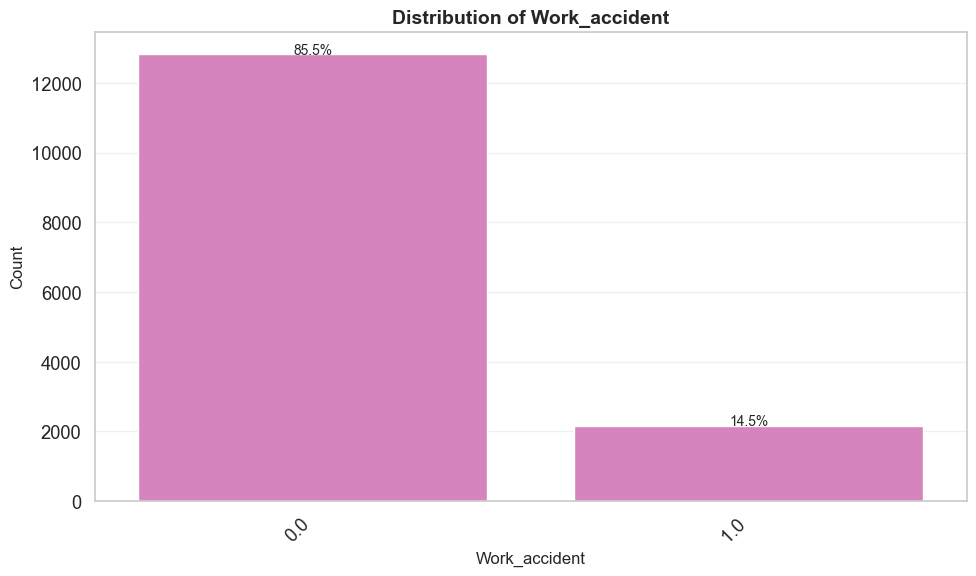


Summary for Work_accident:
Mode: 0.0
+---------+---------+--------------------------+
|   Value |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
|       0 |   12831 |                     85.5 |
|       1 |    2169 |                     14.5 |
+---------+---------+--------------------------+




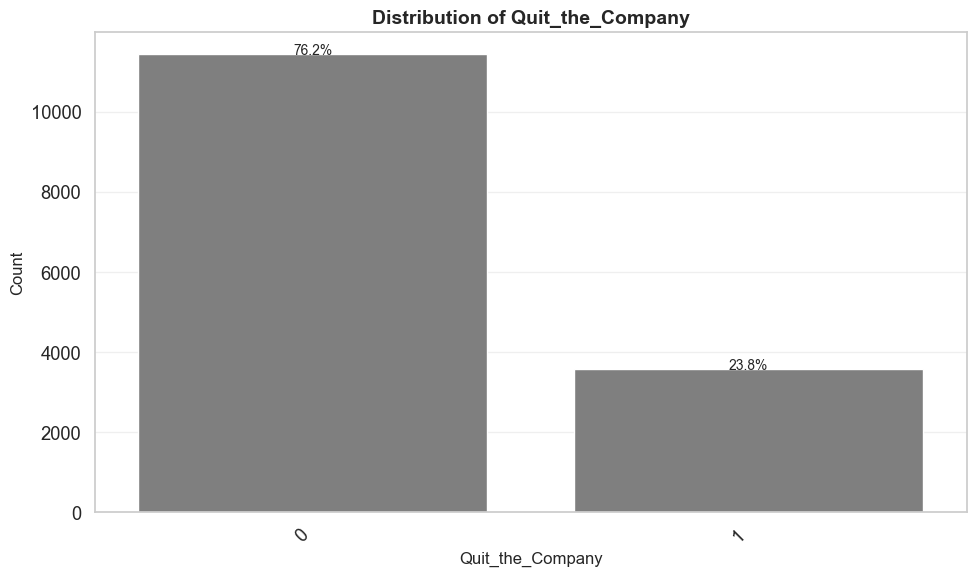


Summary for Quit_the_Company:
Mode: 0
+---------+---------+--------------------------+
|   Value |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
|       0 |   11428 |                     76.2 |
|       1 |    3576 |                     23.8 |
+---------+---------+--------------------------+




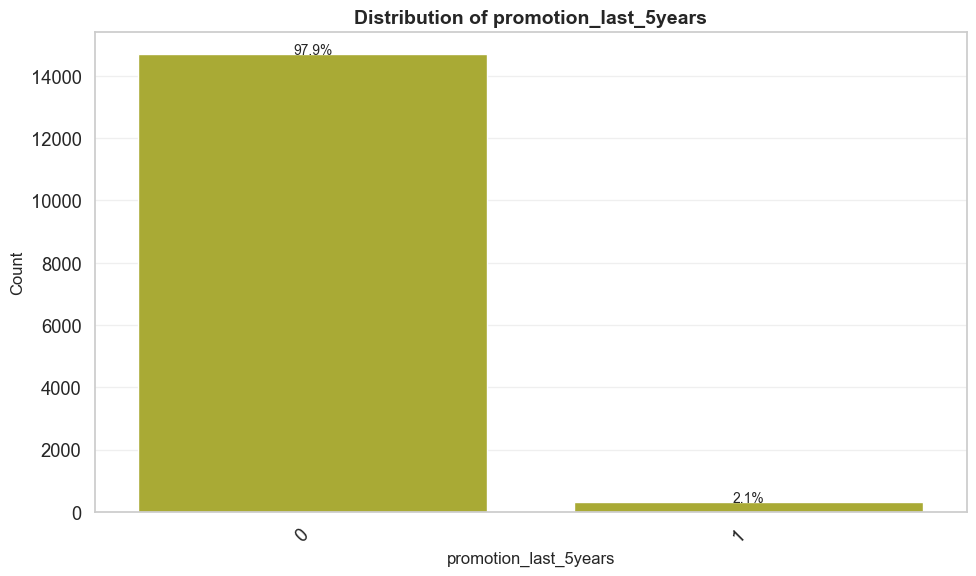


Summary for promotion_last_5years:
Mode: 0
+---------+---------+--------------------------+
|   Value |   Count |   Relative Frequency (%) |
|---------+---------+--------------------------|
|       0 |   14685 |                     97.9 |
|       1 |     319 |                      2.1 |
+---------+---------+--------------------------+



BIVARIATE ANALYSIS - CHURN FACTORS

--------------------------------------------------
SATISFACTION LEVEL vs CHURN ANALYSIS
--------------------------------------------------

Churn Rate by Satisfaction Level:
+----+--------------------------+--------------------+------------------------+
|    | satisfaction_level_cat   |   Quit_the_Company |   Quit_Rate_Percentage |
|----+--------------------------+--------------------+------------------------|
|  0 | Very Low                 |               0.63 |                  62.54 |
|  1 | Low                      |               0.49 |                  49.39 |
|  2 | Medium                   |               0

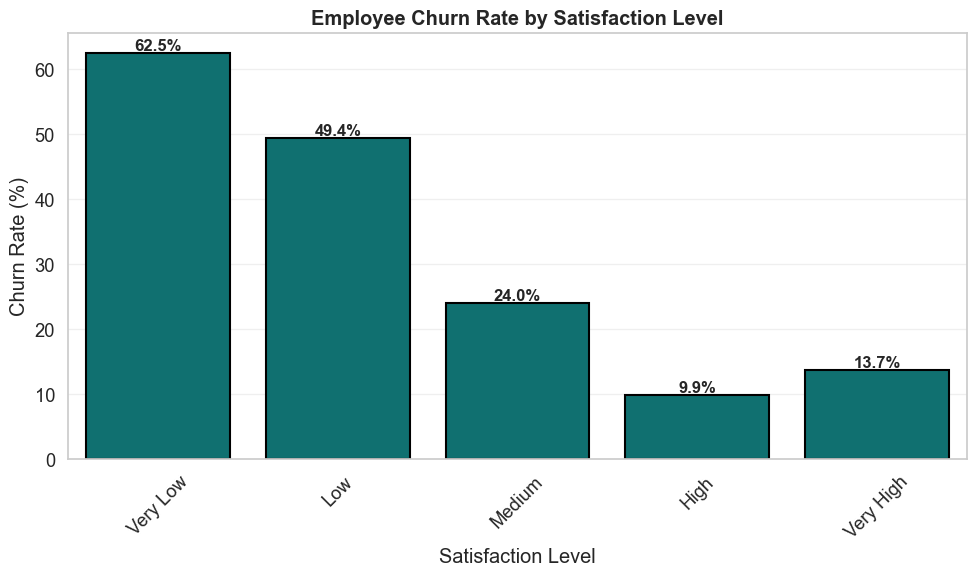


--------------------------------------------------
DEPARTMENT vs CHURN ANALYSIS
--------------------------------------------------

Churn Rate by Department:
+----+---------------+--------------------+------------------------+
|    | Departments   |   Quit_the_Company |   Quit_Rate_Percentage |
|----+---------------+--------------------+------------------------|
|  3 | hr            |               0.29 |                  29.09 |
|  2 | accounting    |               0.27 |                  26.60 |
|  9 | technical     |               0.26 |                  25.62 |
|  8 | support       |               0.25 |                  25.07 |
|  7 | sales         |               0.24 |                  24.49 |
|  5 | marketing     |               0.24 |                  23.66 |
|  0 | IT            |               0.22 |                  22.25 |
|  6 | product_mng   |               0.22 |                  21.95 |
|  1 | RandD         |               0.15 |                  15.37 |
|  4 | manage

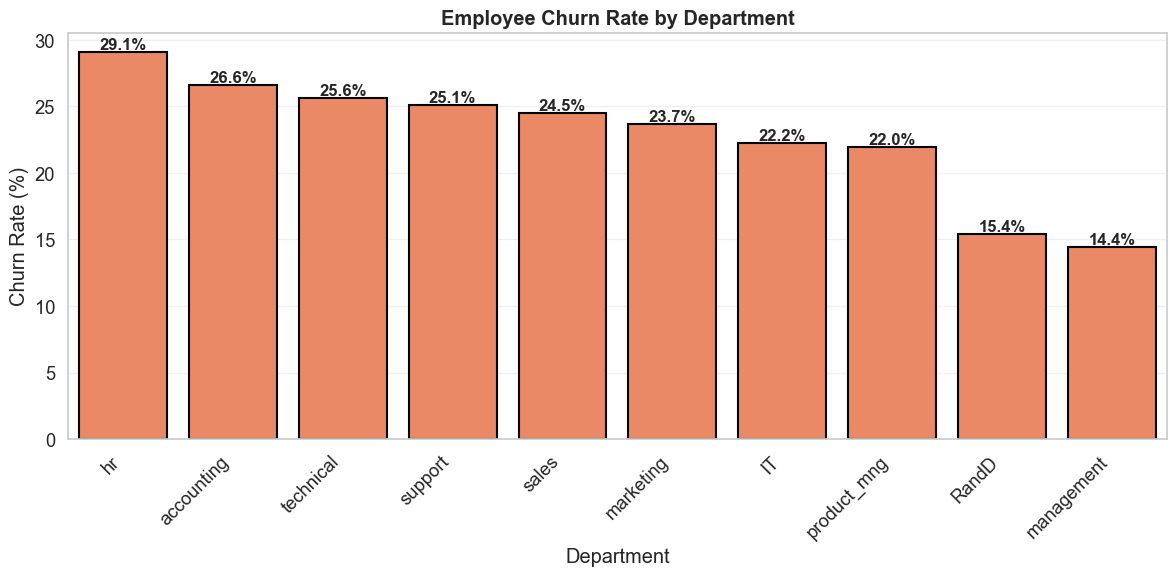


--------------------------------------------------
SALARY LEVEL vs CHURN ANALYSIS
--------------------------------------------------

Churn Rate by Salary Level:
+----+----------+--------------------+------------------------+
|    | salary   |   Quit_the_Company |   Quit_Rate_Percentage |
|----+----------+--------------------+------------------------|
|  1 | low      |               0.30 |                  29.74 |
|  2 | medium   |               0.20 |                  20.43 |
|  0 | high     |               0.07 |                   6.63 |
+----+----------+--------------------+------------------------+


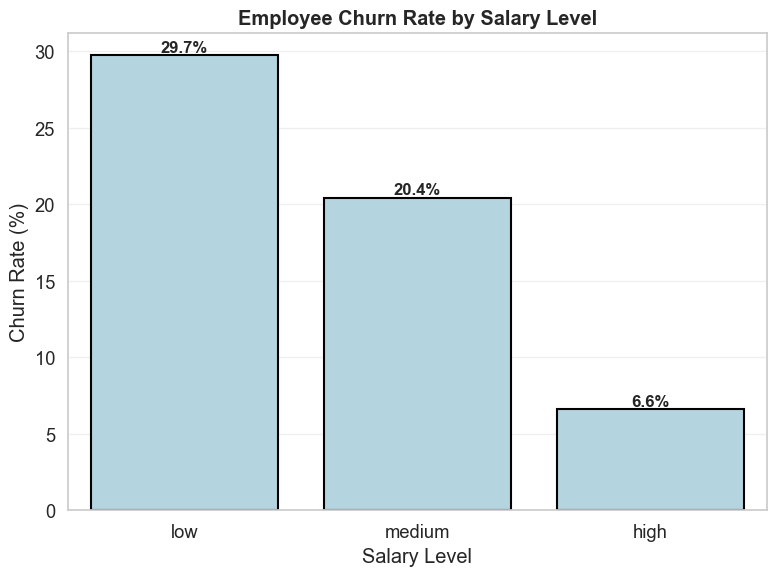


--------------------------------------------------
LAST EVALUATION vs CHURN ANALYSIS
--------------------------------------------------

Churn Rate by Last Evaluation Level:
+----+-----------------------+--------------------+------------------------+
|    | last_evaluation_cat   |   Quit_the_Company |   Quit_Rate_Percentage |
|----+-----------------------+--------------------+------------------------|
|  0 | Very Low              |             nan    |                 nan    |
|  1 | Low                   |               0.00 |                   0.00 |
|  2 | Medium                |               0.34 |                  34.22 |
|  3 | High                  |               0.06 |                   5.83 |
|  4 | Very High             |               0.31 |                  30.82 |
+----+-----------------------+--------------------+------------------------+


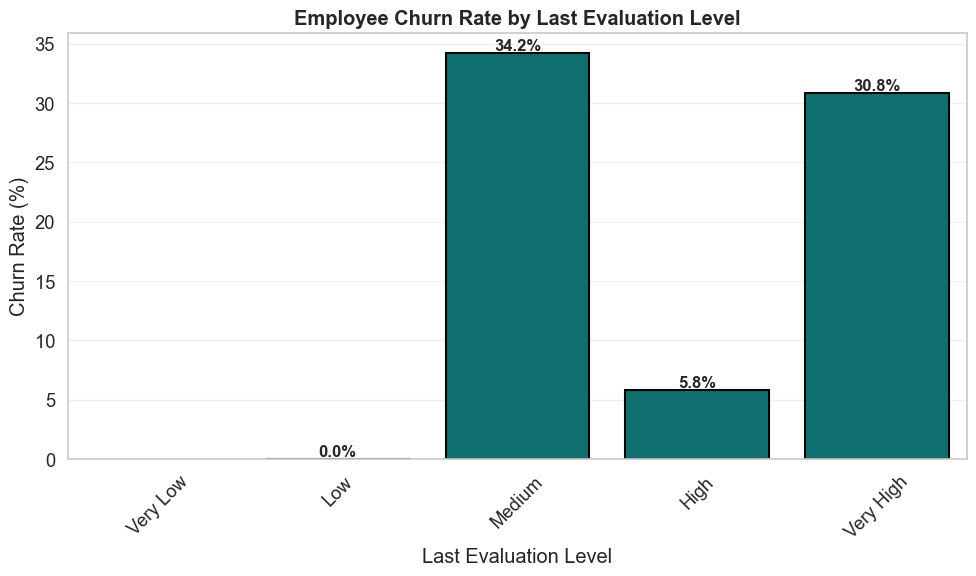


--------------------------------------------------
NUMBER OF PROJECTS vs CHURN ANALYSIS
--------------------------------------------------

Churn Rate by Number of Projects:
+----+------------------+--------------------+------------------------+
|    |   number_project |   Quit_the_Company |   Quit_Rate_Percentage |
|----+------------------+--------------------+------------------------|
|  0 |             2.00 |               0.66 |                  65.62 |
|  1 |             3.00 |               0.02 |                   1.78 |
|  2 |             4.00 |               0.09 |                   9.37 |
|  3 |             5.00 |               0.22 |                  22.17 |
|  4 |             6.00 |               0.56 |                  55.79 |
|  5 |             7.00 |               1.00 |                 100.00 |
+----+------------------+--------------------+------------------------+


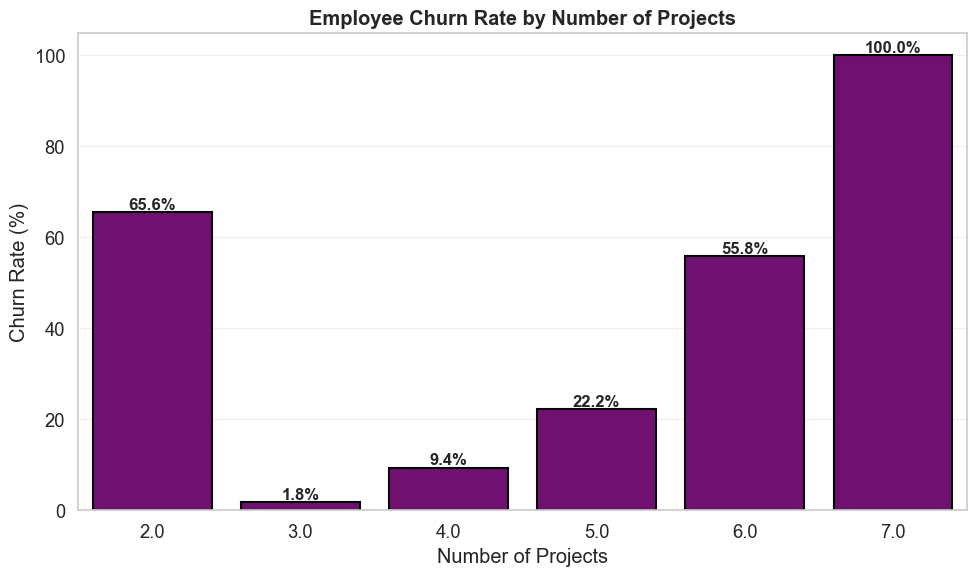


--------------------------------------------------
PROMOTION vs CHURN ANALYSIS
--------------------------------------------------

Churn Rate by Promotion Status:
+----+--------------------+------------------------+
|    | promotion_status   |   Quit_Rate_Percentage |
|----+--------------------+------------------------|
|  0 | No Promotion       |                  24.22 |
|  1 | Promoted           |                   5.96 |
+----+--------------------+------------------------+


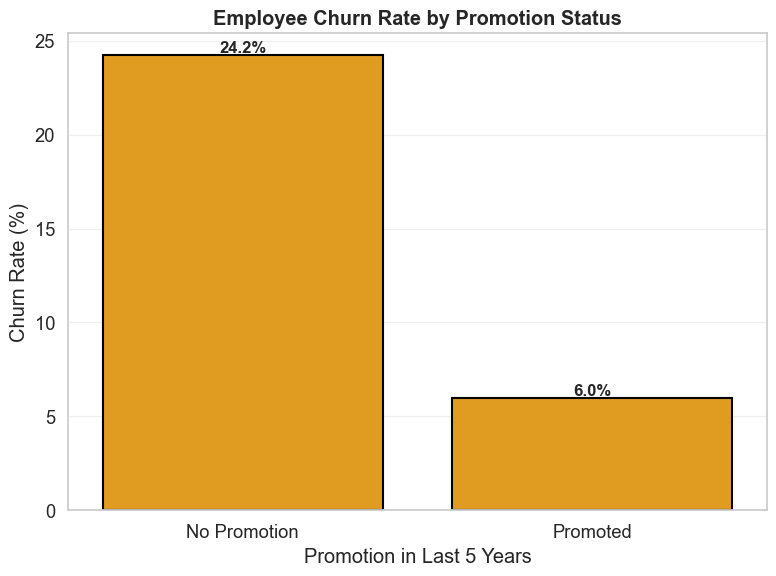


--------------------------------------------------
TENURE vs CHURN ANALYSIS
--------------------------------------------------

Churn Rate by Tenure:
+----+----------------------+--------------------+------------------------+
|    |   time_spend_company |   Quit_the_Company |   Quit_Rate_Percentage |
|----+----------------------+--------------------+------------------------|
|  0 |                 2.00 |               0.02 |                   1.63 |
|  1 |                 3.00 |               0.25 |                  24.62 |
|  2 |                 4.00 |               0.35 |                  34.81 |
|  3 |                 5.00 |               0.57 |                  56.55 |
|  4 |                 6.00 |               0.29 |                  29.11 |
|  5 |                 7.00 |               0.00 |                   0.00 |
|  6 |                 8.00 |               0.00 |                   0.00 |
|  7 |                10.00 |               0.00 |                   0.00 |
+----+-------

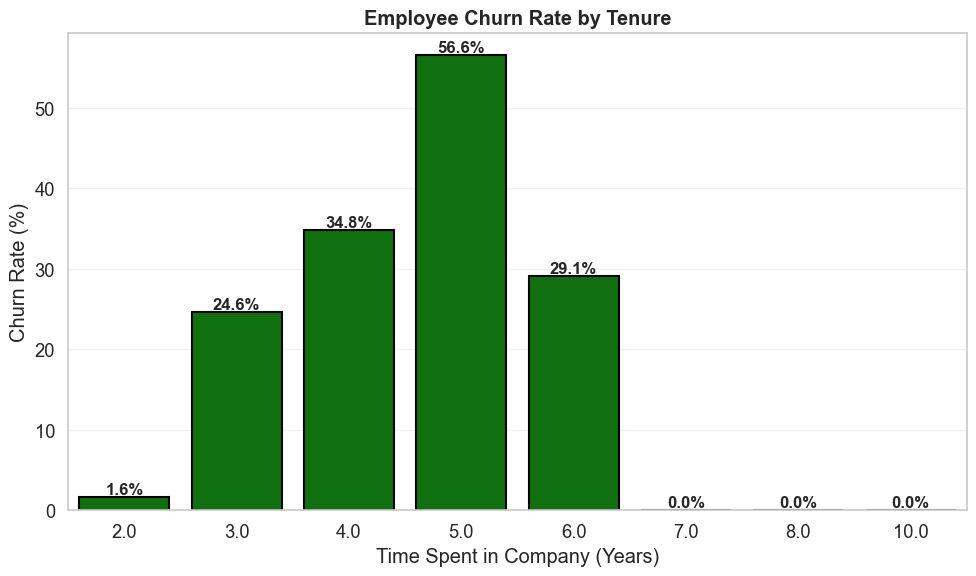


--------------------------------------------------
WORK ACCIDENT vs CHURN ANALYSIS
--------------------------------------------------

Churn Rate by Work Accident Status:
+----+-------------------+------------------------+
|    | accident_status   |   Quit_Rate_Percentage |
|----+-------------------+------------------------|
|  0 | No Accident       |                  26.52 |
|  1 | Had Accident      |                   7.79 |
+----+-------------------+------------------------+


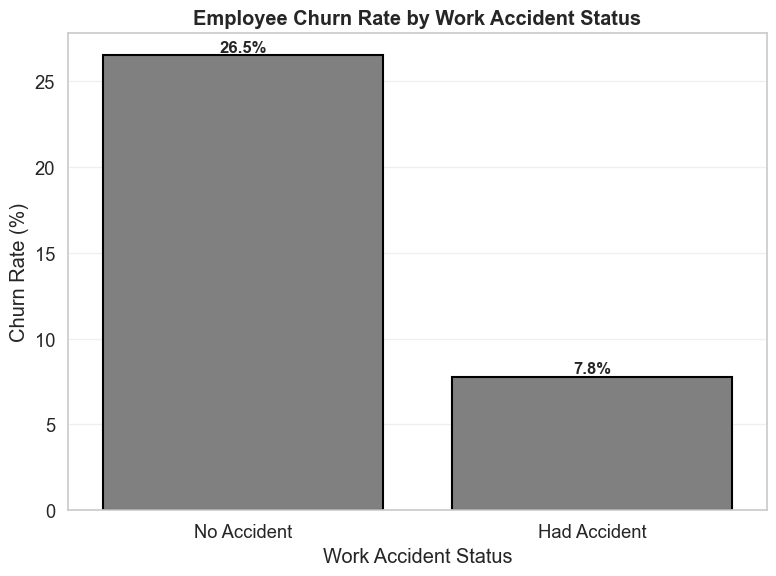


EXECUTIVE SUMMARY
Total Employees: 15,004
Total Churned Employees: 3,576
Overall Churn Rate: 23.83%

KEY INSIGHTS:
----------------------------------------
• Highest risk department: hr (29.1% churn rate)
• Highest risk satisfaction group: Very Low (62.5% churn rate)
• Highest risk salary group: low (29.7% churn rate)

ANALYSIS COMPLETED SUCCESSFULLY!


In [16]:
main()